Statistics, Noise, and C1
=========================

An exploration of the statistical properties of a neutron spectrum generated by mcstas. We have a large data file representing the the neutron flux out of the NG-C guide. It contains 10,890,637,973 neutron events with a total intensity of $2.97133\times{}10^{11}$ neutrons.

mcstas tracks neutron events but assigns each a weight, the intensity, which actually corresponds to the modelled neutron flux. Each also comes with a measure of the uncertainty in the intensity that incorporates both the neutron event uncertainty and the uncertainty from probability, as set out in the section 2.2 of the mcstas manual.

Let's start by comparing the mcstas uncertainty in each spectral value with the simple Poisson model. I start with some tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
NSpectrum.py
Tools to play with a neutron spectrum generated by the mcstas
wavelength monitor instrument.
It generates output files with 26 header lines some of whic contain
information of significant interest, enough to be worth parsing the
header quite carefully. The header parser should be dictionary driven and
returns an instance of a dictionary. Start simple!
Start simpler! Ignore the header. Just count the number of data lines.

Created on Fri Dec 16 12:33:11 2022
Re-written Dec 22 to make NSpectrum independent of the file so that
spectra can be created from other spectra and in other ways.

Upgraded Dec 22 to support computing the BL3 correction coefficient.

@author: bcollett
"""
import numpy as np
import matplotlib.pyplot as plt

#
# Start by defining a dictionary to guide the parser.
# Each key is a single string that will be matched in the input file
# and then the value is another dictionary giving the names and types of
# expected arguments.
# The following types of arguemnt are recognized
# 'name'
#
# We will start with the simple list for the format line.
n_dict = {'Format': 100, 'Creator': 102, 'NCount': 104, 'type': 110}
letter = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz_'
delim = '();='


def get_word(the_str, start):
    idx = start
    stop = len(the_str)
    while the_str[idx] not in letter:
        if idx < stop:
            idx += 1
        else:
            break


class NSpectrum:
    # Class variable fonts used in plotting.
    rfont = {'family': 'serif',
             'color':  'red',
             'weight': 'normal',
             'size': 14,
             }
    bfont = {'family': 'serif',
             'color':  'blue',
             'weight': 'normal',
             'size': 14,
             }
    kfont = {'family': 'serif',
             'color':  'black',
             'weight': 'normal',
             'size': 14,
             }

    # Allows creation from a file, a size, or just as a template
    # Members are
    # data n x 4 array of waveleng, intensity, uncertainty, count
    # n_data number of data
    # tot_inten integral of intensity column
    # max_inten max of intensity column
    # tot_count integral of count column
    # max_count max of count column
    def __init__(self, fileName=None, clone=None, size=500):
        if fileName is not None:
            print(f'Load nfile {fileName}')
            self.filename = fileName
            ifp = open(fileName, 'r')
            lines = ifp.readlines()
            ifp.close()
            nLine = len(lines)
            print(f'Read {nLine} lines from {fileName}')
            self.n_data = 0
            for line in lines:
                # print(line[0], line)
                if line[0] == '#':
                    print(f'Comment> {line}')
                else:
                    self.n_data += 1
            print(f'{self.n_data} lines of data.')
            self.data = np.zeros((self.n_data, 4))
            self.n_data = 0
            for line in lines:
                # print(line[0], line)
                if line[0] != '#':
                    words = line.split(' ')
                    self.data[self.n_data, 0] = float(words[0])
                    self.data[self.n_data, 1] = float(words[1])
                    self.data[self.n_data, 2] = float(words[2])
                    self.data[self.n_data, 3] = float(words[3])
                    self.n_data += 1
        elif clone is not None:
            self.n_data = clone.n_data
            self.data = clone.data[:, :]
        else:
            self.n_data = size
            self.dat = np.zeros((self.n_data, 4))
        self.tot_inten = np.sum(self.data[:, 1])
        self.max_inten = np.max(self.data[:, 1])
        self.tot_count = np.sum(self.data[:, 3])
        self.max_count = np.max(self.data[:, 3])

    def plot(self):
        fig, ax1 = plt.subplots(figsize=(10, 5))
        # plt.subplots_adjust(bottom=0.15)
        ax2 = ax1.twinx()
        ax1.errorbar(self.data[:, 0], self.data[:, 1],
                     yerr=self.data[:, 2], fmt='b.')
        ax2.plot(self.data[:, 0], self.data[:, 3], 'r.')
        ax1.set_ylabel('Neutron Intensity (blue)',
                       fontdict=NSpectrum.bfont)
        ax2.set_ylabel('Number of events tracked (red)',
                       fontdict=NSpectrum.rfont)
        ax1.set_xlabel('Wavelength (Angstroms)',
                       fontdict=NSpectrum.kfont)
        fig.suptitle(f'Spectrum from {self.filename}',
                     fontdict=NSpectrum.kfont)
        ypos = 0.15 * self.max_inten
        ax1.text(15, ypos, f'Tot. Intensity {self.tot_inten}')

    #
    # Determine whether an argument represents a congruent
    # NSpectrum; one with same length, start, and stop
    def isCongruent(self, newSpect):
        if isinstance(newSpect, NSpectrum):
            if self.n_data != newSpect.n_data:
                print(f'Add-in spectrum size {newSpect.nData} does not'
                      f'match size of spectrum {self.nData}.')
                return False
            if self.data[0, 0] != newSpect.data[0, 0]:
                print(f'Add-in spectrum start {newSpect.data[0, 0]} does not'
                      f'match start of spectrum {self.data[0, 0]}.')
                return False
            if self.data[-1, 0] != newSpect.data[-1, 0]:
                print(f'Add-in spectrum end {newSpect.data[-1, 0]} does not'
                      f'match end of spectrum {self.data[-1, 0]}.')
                return False
            return True

    # This supports adding another spectrum to this one to yield
    # a new one.
    def plus(self, newSpect):
        if not self.isCongruent(newSpect):
            print('Can only add another similar spectrum.'
                  f'Got {type(newSpect)}')
            return None
        new = NSpectrum(clone=self)
        new.data[:, 1] += newSpect.data[:, 1]
        new.data[:, 2] = np.sqrt(self.data[:, 2]**2 + newSpect.data[:, 2]**2)
        new.data[:, 3] += newSpect.data[:, 3]
        new.tot_inten = np.sum(self.data[:, 1])
        new.max_inten = np.max(self.data[:, 1])
        new.tot_count = np.sum(self.data[:, 3])
        new.max_count = np.max(self.data[:, 3])
        return new

    # This computes the BL3 C1 correction coefficient using this
    # spectrum. It uses a simple Monte Carlo method to estimate
    # the uncertainty in the value.

The data set BL3FrontFullGridBack has the front 4-jaw slit open all the way and then the CDR collimator system with a full aspect wavelength monitor, a 3x3 grid of wavelength monitors, and a position sensitive detector to image the neutron spot. Let's load the full spectrum from the big monitor.

In [3]:
full = NSpectrum('BL3FrontFullGridBack/IntensityVsWavelength_Big.csv')

Load nfile BL3FrontFullGridBack/IntensityVsWavelength_Big.csv
Read 1026 lines from BL3FrontFullGridBack/IntensityVsWavelength_Big.csv
Comment> # Format: McCode with text headers

Comment> # URL: http://www.mccode.org

Comment> # Creator: McStas 3.1 - Nov. 24, 2021

Comment> # Instrument: Bl3FrontFullGridBack.instr

Comment> # Ncount: 10890637973

Comment> # Trace: no

Comment> # Gravitation: no

Comment> # Seed: 1671291533905179

Comment> # Directory: /Users/bcollett/Documents/mcstas/Bl3FrontFullGridBack_20221217_103853

Comment> # Date: Sat Dec 17 11:49:33 2022 (1671295773)

Comment> # type: array_1d(1000)

Comment> # Source: JSThesis (Bl3FrontFullGridBack.instr)

Comment> # component: wavelength_monitor

Comment> # position: 0 0 8.0225

Comment> # title: Wavelength monitor

Comment> # Ncount: 10890637973

Comment> # filename: IntensityVsWavelength_Big.csv

Comment> # statistics: X0=4.38815; dX=2.19838;

Comment> # signal: Min=0; Max=4.96541e+06; Mean=529217;

Comment> # values: 5.292

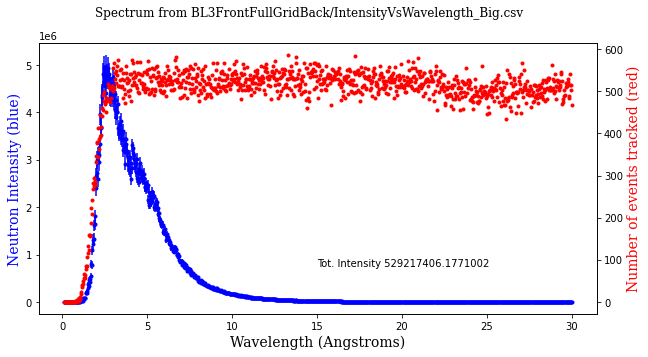

In [4]:
full.plot()

We see that there is slightly less intensity than I thought but the structure is all here. It is interesting to see that the number of neutron events per channel is essentially constant above about 3 A and below that the cut-off in events matches the cut-off in intensity suggesting that it arises from the curved guide's ability to prevent high velocity neutrons from makeing it through the guide. We are tracking about 500 neutrons per channel so we have noise in the number of tracks at the $\sqrt{500}=22$ level.

We see the error bars in the intensity graph and they look to be at a reasonable level. Let's compare the values of the error bars with the Poisson error.

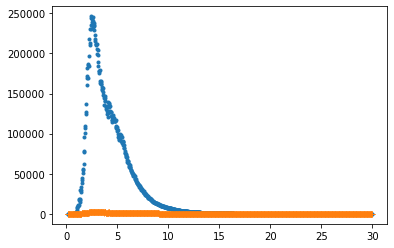

In [5]:
mc_errs = full.data[:, 2]
mc_inten = full.data[:, 1]
p_errs = np.sqrt(mc_inten)
mc_ls = full.data[:, 0]
plt.plot(mc_ls, mc_errs, '.')
plt.plot(mc_ls, p_errs, '+')

So we see that the mcstas errors are MUCH larger than simple Poisson statistics would indicate.

In [6]:
print(np.max(mc_errs))
print(np.max(p_errs))

246245.7551
2228.319319576977


Apparently the mcstas errors are more than 100 times as large as simple Poisson statistics.

This may invalidate the simple MC statistics that Merrill added to the spectrum. Instead of using Poisson to add noise to the spectrum I am going to use numpy.generator.normal to create multiple spectra with noise controlled by the mcstas error.

First we need the function to evaluate the C1 correction.

In [7]:
class Correction:
    def __init__(self):
        self.rho = 39.3E-6 / 1e-4  # LiF density, g/m^2
        self.sigma = 941E-28  # m^2 reference absorbtion
        self.ArealDensity = 6.01512  # g/mol
        self.C0 = self.rho * self.sigma * physics.N_A / self.ArealDensity
        self.kn = physics.hc * physics.c / physics.m_n
        # print(f'kn = {self.kn}')
        # print(f'C0 = {self.C0}')
        self.v0 = 2200  # m/s Reference velocity for absorbtion
        self.lamb0 = self.kn / self.v0  # Angstroms reference wavelength
        # print(self.lamb0)
        self.tau_n = 886.3  # s Neutron lifetime

    def C1_Scott(self, lamb, inten):
        # Numerator integral
        num = np.sum(self.C0 * lamb * inten / self.lamb0)
        # print(num)
        # Denominator
        pre = 1 - np.exp(-self.C0 * lamb / self.lamb0)
        denom = np.sum(pre * inten)
        # print(denom)
        C1 = num / denom
        # print(f"Scott's 'C1 = {C1}")
        return C1

    def C1_BC(self, lamb, inten):
        # Numerator integral
        num = simps(self.C0 * lamb * inten / self.lamb0, lamb)
        # print(num)
        # Denominator
        pre = 1 - np.exp(-self.C0 * lamb / self.lamb0)
        denom = simps(pre * inten, lamb)
        # print(denom)
        C1 = num / denom
        # print(f"BC's C1 = {C1}")
        return C1

    def C1ToCorr(self, C1):
        return self.tau_n * (C1 - 1)

    def CorrScott(self, lamb, inten):
        return self.C1ToCorr(self.C1_Scott(lamb, inten))

    def CorrBC(self, lamb, inten):
        return self.C1ToCorr(self.C1_BC(lamb, inten))


Let's start with the correction for the original spectrum.

In [8]:
from scipy.integrate import simps

class Physics:
    def __init__(self): # Particle rest masses in eV/c^2
        self.m_e = 0.510998950E6  # eV/c^2
        self.m_p = 938.272088E6
        self.m_n = 939.565420E6
        # hc converts between wavelength and momentum (pc in eV)
        self.hc = 12_398.4  # eV.nm
        self.c = 299_792_458  # m/s
        # Avogadro's number
        self.N_A = 6.02214076E23  # /mol

physics = Physics()
c = Correction()

fullC1 = c.CorrBC(mc_ls, mc_inten)

print(f'Full C1 = {fullC1} s')

Full C1 = 5.012816652268445 s


Now we use the numpy normal distribution generator to make a randomized version of the intensity.

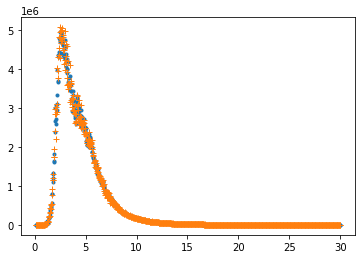

In [9]:
r_inten = np.random.default_rng().normal(mc_inten, mc_errs)
plt.plot(mc_ls, mc_inten, '.')
plt.plot(mc_ls, r_inten, '+')

OK, that looks MUCH more believable than a test I did with Poisson. Let's see the effect on C1.

In [10]:
print(c.CorrBC(mc_ls, r_inten))

5.010160851392532


So let's try doing that 100 times and look at the results.

In [11]:
C1s = np.zeros(100)

for t in range(100):
    t_inten = np.random.default_rng().normal(mc_inten, mc_errs)
    C1s[t] = c.CorrBC(mc_ls, t_inten)
avg_C1 = np.average(C1s)
std_C1 = np.std(C1s)
print(f'Averaged C1 is {avg_C1}+/-{std_C1} s')

Averaged C1 is 5.012782471637953+/-0.005126932628853609 s


Excellent. So we have a way to evaluate a C1 with an uncertainty that we can build into the correction system.
The good news is that, at least with this large a spectrum, we are getting excellent (0.1%) accuracy from our C1s.

What if we try it with a MUCH smaller spectrum? BCLeftThird was a run with the 4-jaw slit stopped down to let through only a 2cm wide slice of the full beam, from x=-3cm to x=-1cm. The spectra were recorded in 9 segments so let us use one one of those for a retest.

Load nfile Bl3LeftThird/LMon02csv.dat
Read 528 lines from Bl3LeftThird/LMon02csv.dat
Comment> # Format: McCode with text headers

Comment> # URL: http://www.mccode.org

Comment> # Creator: McStas 3.1 - Nov. 24, 2021

Comment> # Instrument: Bl3FrontAdjGridBack.instr

Comment> # Ncount: 10890637973

Comment> # Trace: no

Comment> # Gravitation: no

Comment> # Seed: 1671651364737922

Comment> # Directory: Bl3FrontAdjGridBack_20221221_143604

Comment> # Param: left=-0.03

Comment> # Param: right=-0.01

Comment> # Date: Wed Dec 21 16:07:31 2022 (1671656851)

Comment> # type: array_1d(500)

Comment> # Source: BL3Beam (Bl3FrontAdjGridBack.instr)

Comment> # component: wavelength_monitor_2

Comment> # position: 0 0 8.0225

Comment> # title: Wavelength monitor

Comment> # Ncount: 10890637973

Comment> # filename: LMon02csv.dat

Comment> # statistics: X0=4.40753; dX=2.19117;

Comment> # signal: Min=0; Max=285226; Mean=22890.2;

Comment> # values: 1.14451e+07 269823 10528

Comment> # xvar: L

Com

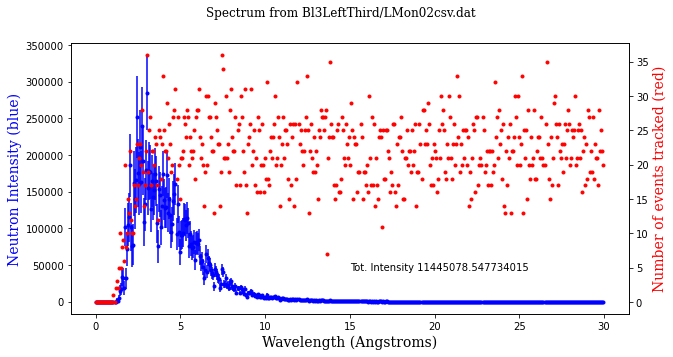

In [12]:
s02 = NSpectrum('Bl3LeftThird/LMon02csv.dat')
s02.plot()

The full C1 from that is given by

In [13]:
s_ls = s02.data[:, 0]
s_is = s02.data[:, 1]
s_es = s02.data[:, 2]
print(c.CorrBC(s_ls, s_is))

5.019696742993703


Then we do the full statistical thing to get

In [14]:
sC1s = np.zeros(100)

for t in range(100):
    t_inten = np.random.default_rng().normal(s_is, s_es)
    sC1s[t] = c.CorrBC(s_ls, t_inten)
savg_C1 = np.average(sC1s)
sstd_C1 = np.std(sC1s)
print(f'S02 averaged C1 is {savg_C1}+/-{sstd_C1} s')

S02 averaged C1 is 5.02701879206539+/-0.028874935651598665 s


Excellent, so with this much smaller spectrum we get, as we would expect,  nearly 1% uncertainty in the value of the C1 correction.

How many events do we need?
---------------------------

I want to re-do Merrill's computation of how many neutrons we need to count in order to get a reliable value for C1 in the absence of external noise.

The basic method is to take a high accuracy spectrum and scale it down to lower and lower numbers of total counts and to look at how many counts you need to bring the value of C1 to within 0.1 s of its ideal value. For these purposes we treat the numeric spectrum as ideal and use only Poisson statistics to do error estimation since we work with scaled versions of the spectrum.

For this noise-free version of the calculation I will use the numpy.floor function to reduce all the intensities to counts.

In [15]:
raw_tot = np.sum(mc_inten)
print(raw_tot)

529217406.1771002


So, let's scale this to a total intensity of 10,000.

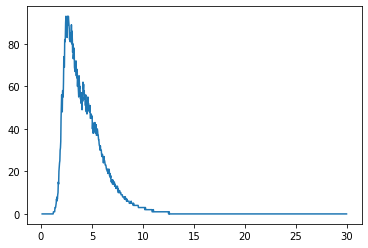

In [16]:
si10k = np.floor(mc_inten * 10_000 / raw_tot)
plt.plot(mc_ls, si10k)

Now we need code to compute the C1 and its uncertainty using just poisson statistics.

In [17]:
def C1err(lambs, intens):
    sC1s = np.zeros(100)

    for t in range(100):
        t_inten = np.floor(np.random.default_rng().poisson(intens))
        sC1s[t] = c.CorrBC(lambs, t_inten)
    savg_C1 = np.average(sC1s)
    sstd_C1 = np.std(sC1s)
    return savg_C1, sstd_C1

c110k,e10k = C1err(mc_ls, si10k)
print(f'At 10k C1 = {c110k}+/-{e10k} s')

At 10k C1 = 4.635743627211216+/-0.022502403924982924 s


At 100k C1 = 4.893759934719527+/-0.011058626917828152 s


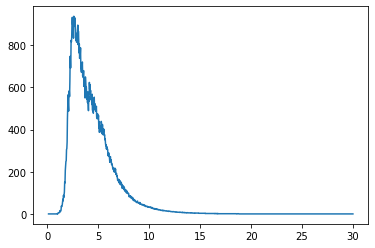

In [18]:
si100k = np.floor(mc_inten * 100_000 / raw_tot)
plt.plot(mc_ls, si100k)
c1100k,e100k = C1err(mc_ls, si100k)
print(f'At 100k C1 = {c1100k}+/-{e100k} s')

At 1M C1 = 4.989215944075068+/-0.0038419308534679247 s


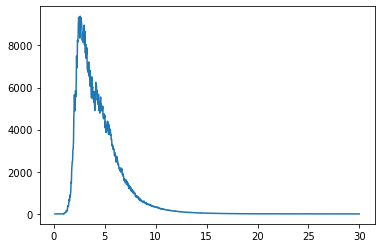

In [19]:
si1M = np.floor(mc_inten * 1_000_000 / raw_tot)
plt.plot(mc_ls, si1M)
c11M,e1M = C1err(mc_ls, si1M)
print(f'At 1M C1 = {c11M}+/-{e1M} s')

At 10M C1 = 5.010348807025732+/-0.0012790358998841375 s


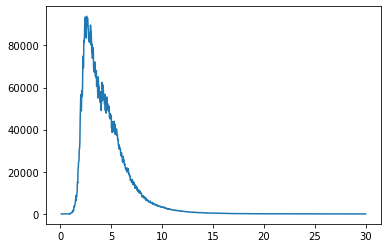

In [20]:
si10M = np.floor(mc_inten * 10_000_000 / raw_tot)
plt.plot(mc_ls, si10M)
c110M,e10M = C1err(mc_ls, si10M)
print(f'At 10M C1 = {c110M}+/-{e10M} s')

At 100M C1 = 5.0126506099540675+/-0.0003764776365787743 s


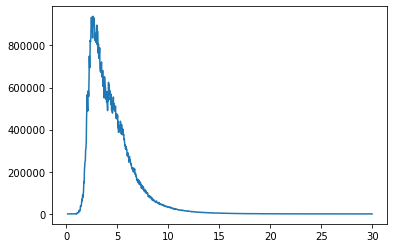

In [21]:
si100M = np.floor(mc_inten * 100_000_000 / raw_tot)
plt.plot(mc_ls, si100M)
c1100M,e100M = C1err(mc_ls, si100M)
print(f'At 100M C1 = {c1100M}+/-{e100M} s')

So it took 100M counts to get the value correct. And this is without noise.

At 1000M C1 = 5.012758776776594+/-0.00012835320866672452 s


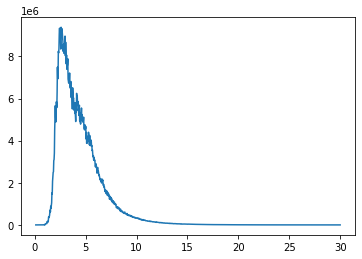

In [22]:
si1G = np.floor(mc_inten * 1_000_000_000 / raw_tot)
plt.plot(mc_ls, si1G)
c11G,e1G = C1err(mc_ls, si1G)
print(f'At 1000M C1 = {c11G}+/-{e1G} s')

So, plotting those as Merrill did we get

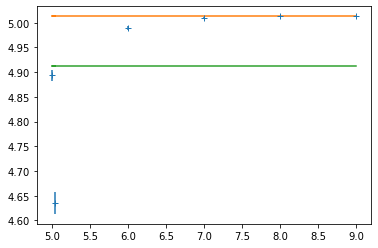

In [25]:
scaledCs = [c110k, c1100k, c11M, c110M, c1100M, c11G]
scales = [11e4, 1e5, 1e6, 1e7, 1e8, 1e9]
scaledEs = [e10k, e100k, e1M, e10M, e100M, e1G]
ideal = [fullC1]*6
lower = [fullC1-0.1]*6
plt.errorbar(np.log10(scales), scaledCs, yerr=scaledEs, fmt='+')
plt.plot(np.log10(scales), ideal)
plt.plot(np.log10(scales), lower)

So we are within 0.1s by about 20k total counts. I guess that that is not SO different from Merrill's value. But it seems more different because I have uncertainties.